# ARIMA Model 

In [1]:
# import required libarries 
import pandas as pd
import numpy as np
import yfinance as yf 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

### Data Collection 

Download data first. Collect the data from yfinance API. The data should be 1-day period, 1-week period, 1-year period and 10-years period.

In [2]:
# one day - 1 min interval
gold_one_day = yf.download('GC=F', interval="1m")
# one month - 5 min interval
gold_one_month = yf.download('GC=F', interval="5m", period="1mo")
# one year - 1 day interval
gold_one_year = yf.download('GC=F', period="1y")
# ten years - 1 day interval 
gold_ten_year = yf.download('GC=F', period="10y")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Data Preprocessing 

Check the data to make sure no missing values. 

In [3]:
# check for missing values
for index, i in {"gold_one_day": gold_one_day, "gold_one_month": gold_one_month, 
                 "gold_one_year": gold_one_year, "gold_one_year": gold_one_year, "gold_ten_year": gold_ten_year}.items():
    print(index)
    print("------------")
    print(i.isna().sum(), end="\n\n")

gold_one_day
------------
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

gold_one_month
------------
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

gold_one_year
------------
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

gold_ten_year
------------
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64



Great! There is no missing value. Save the data set for later use. Need to update everyday for the latest data. 

In [4]:
# save the data as csv file
gold_one_day.to_csv('data/gold_one_day.csv')
gold_one_month.to_csv('data/gold_one_month.csv')
gold_one_year.to_csv('data/gold_one_year.csv')
gold_ten_year.to_csv('data/gold_ten_year.csv')

### Load the CSV files into dataframes. 

In [5]:
# Load the data sets 
# load gold data for one day (1 min interval)
df_one_day = pd.read_csv('data/gold_one_day.csv')
# load gold data for one month (5 min interval)
df_one_month = pd.read_csv('data/gold_one_month.csv')
# load gold data for one year (1 day interval)
df_one_year = pd.read_csv('data/gold_one_year.csv')
# load gold data for one year (1 day interval)
df_ten_year = pd.read_csv('data/gold_ten_year.csv')

In [6]:
df_one_year.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-07-11,1925.000000,1937.000000,1924.199951,1931.300049,1931.300049,142
1,2023-07-12,1932.300049,1958.000000,1932.199951,1956.199951,1956.199951,132
2,2023-07-13,1961.099976,1961.099976,1953.000000,1959.199951,1959.199951,121
3,2023-07-14,1958.400024,1960.599976,1952.699951,1960.099976,1960.099976,94
4,2023-07-17,1954.000000,1956.500000,1946.599976,1952.400024,1952.400024,29
5,2023-07-18,1968.800049,1978.400024,1963.400024,1977.199951,1977.199951,83
6,2023-07-19,1977.000000,1977.500000,1973.000000,1977.500000,1977.500000,35
7,2023-07-20,1973.699951,1973.699951,1965.599976,1968.300049,1968.300049,638
8,2023-07-21,1961.800049,1964.300049,1961.800049,1964.300049,1964.300049,50
9,2023-07-24,1965.300049,1965.500000,1960.300049,1960.300049,1960.300049,2


In [7]:
df_one_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       254 non-null    object 
 1   Open       254 non-null    float64
 2   High       254 non-null    float64
 3   Low        254 non-null    float64
 4   Close      254 non-null    float64
 5   Adj Close  254 non-null    float64
 6   Volume     254 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.0+ KB


Drop unnecessary columns named "Adj Close" and "Volume". Datatime column needs to be datatime data type. Convert it right away. 

In [8]:
# drop columns 
df_one_year.drop(columns=['Adj Close', 'Volume'], inplace=True)

In [9]:
# convert Datetime column to datetime datatype 
df_one_year['Date']= pd.to_datetime(df_one_year['Date'])

In [10]:
df_one_year.set_index('Date', inplace=True)

In [11]:
# check the dataframe and data type again 
print(df_one_year.head(3))

print(df_one_year.info())

                   Open         High          Low        Close
Date                                                          
2023-07-11  1925.000000  1937.000000  1924.199951  1931.300049
2023-07-12  1932.300049  1958.000000  1932.199951  1956.199951
2023-07-13  1961.099976  1961.099976  1953.000000  1959.199951
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2023-07-11 to 2024-07-11
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    254 non-null    float64
 1   High    254 non-null    float64
 2   Low     254 non-null    float64
 3   Close   254 non-null    float64
dtypes: float64(4)
memory usage: 9.9 KB
None


In [12]:
print(df_one_year.tail(10))

                   Open         High          Low        Close
Date                                                          
2024-06-27  2296.800049  2329.000000  2295.000000  2324.500000
2024-06-28  2325.399902  2338.300049  2319.000000  2327.699951
2024-07-01  2323.800049  2329.699951  2321.699951  2327.600098
2024-07-02  2330.699951  2334.600098  2323.000000  2323.000000
2024-07-03  2330.899902  2361.600098  2330.899902  2359.800049
2024-07-05  2354.899902  2388.500000  2354.899902  2388.500000
2024-07-08  2381.699951  2383.800049  2352.800049  2355.199951
2024-07-09  2363.100098  2363.699951  2360.100098  2360.100098
2024-07-10  2366.300049  2377.000000  2365.800049  2372.199951
2024-07-11  2377.399902  2418.699951  2376.800049  2403.000000


In [13]:
#  check the frequency 
df_one_year.index

DatetimeIndex(['2023-07-11', '2023-07-12', '2023-07-13', '2023-07-14',
               '2023-07-17', '2023-07-18', '2023-07-19', '2023-07-20',
               '2023-07-21', '2023-07-24',
               ...
               '2024-06-27', '2024-06-28', '2024-07-01', '2024-07-02',
               '2024-07-03', '2024-07-05', '2024-07-08', '2024-07-09',
               '2024-07-10', '2024-07-11'],
              dtype='datetime64[ns]', name='Date', length=254, freq=None)

In [14]:
def data_wrangle(path, droped_columns):
    """ A method that will clean the original dataset, 
        restructure the dataset and fill the missing values.
        
        input
        -----
        path: data path 
        dropped_columns: columns to be dropped"""
    
    # read the dataset through the path
    df=pd.read_csv(path)
    # change the "Date" column to datetime data type
    df['Date']=pd.to_datetime(df['Date'])
    # set the "Date" column to index
    df=df.set_index('Date')
    # assigned the desired frequecy to set up
    # 'D' stands for day
    desired_frequency = 'D'
    # set the frequency 
    df = df.asfreq(desired_frequency)
    # drop the unnecessary columns that are already specified 
    df = df.drop(columns=droped_columns)
    # fill the missing values 
    df=df.fillna(method='ffill')
    return df

In [15]:
df_one_year_1 = data_wrangle('data/gold_one_year.csv', ['Adj Close', 'Volume'])

C:\Users\user\AppData\Local\Temp\ipykernel_12860\493660491.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df=df.fillna(method='ffill')


In [16]:
df_one_year_1.head(10)

,Open,High,Low,Close
Date,,,,
2023-07-11,1925.000000,1937.000000,1924.199951,1931.300049
2023-07-12,1932.300049,1958.000000,1932.199951,1956.199951
2023-07-13,1961.099976,1961.099976,1953.000000,1959.199951
2023-07-14,1958.400024,1960.599976,1952.699951,1960.099976
2023-07-15,1958.400024,1960.599976,1952.699951,1960.099976
2023-07-16,1958.400024,1960.599976,1952.699951,1960.099976
2023-07-17,1954.000000,1956.500000,1946.599976,1952.400024
2023-07-18,1968.800049,1978.400024,1963.400024,1977.199951
2023-07-19,1977.000000,1977.500000,1973.000000,1977.500000


In [17]:
print(len(df_one_year))

254


In [18]:
print(len(df_one_year_1))

367


In [19]:
df_one_year_1.tail(10)

,Open,High,Low,Close
Date,,,,
2024-07-02,2330.699951,2334.600098,2323.000000,2323.000000
2024-07-03,2330.899902,2361.600098,2330.899902,2359.800049
2024-07-04,2330.899902,2361.600098,2330.899902,2359.800049
2024-07-05,2354.899902,2388.500000,2354.899902,2388.500000
2024-07-06,2354.899902,2388.500000,2354.899902,2388.500000
2024-07-07,2354.899902,2388.500000,2354.899902,2388.500000
2024-07-08,2381.699951,2383.800049,2352.800049,2355.199951
2024-07-09,2363.100098,2363.699951,2360.100098,2360.100098
2024-07-10,2366.300049,2377.000000,2365.800049,2372.199951


# Data Visualization

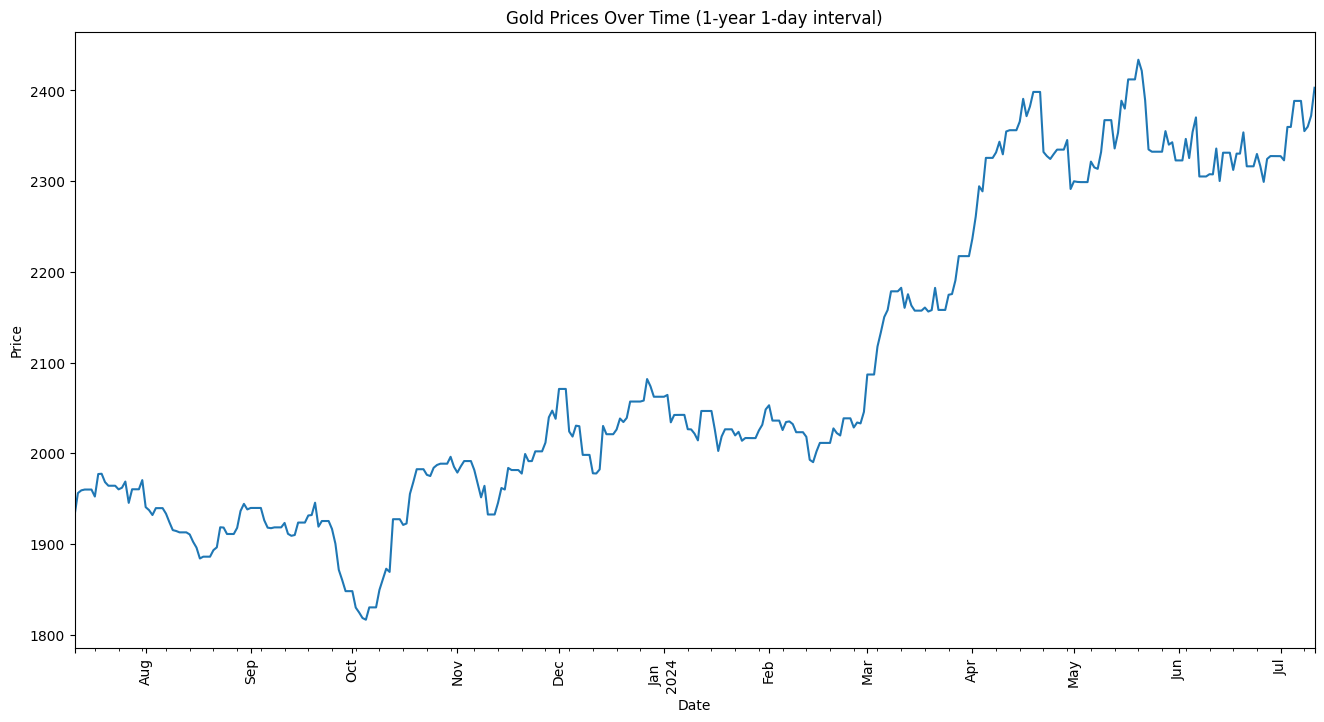

In [20]:
# Create a plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the DataFrame
df_one_year_1['Close'].plot(ax=ax)

plt.title('Gold Prices Over Time (1-year 1-day interval)')
plt.xlabel('Date')
plt.ylabel('Price')

# Rotate x-axis labels 90 degrees
plt.xticks(rotation=90)

# Show plot
plt.show()

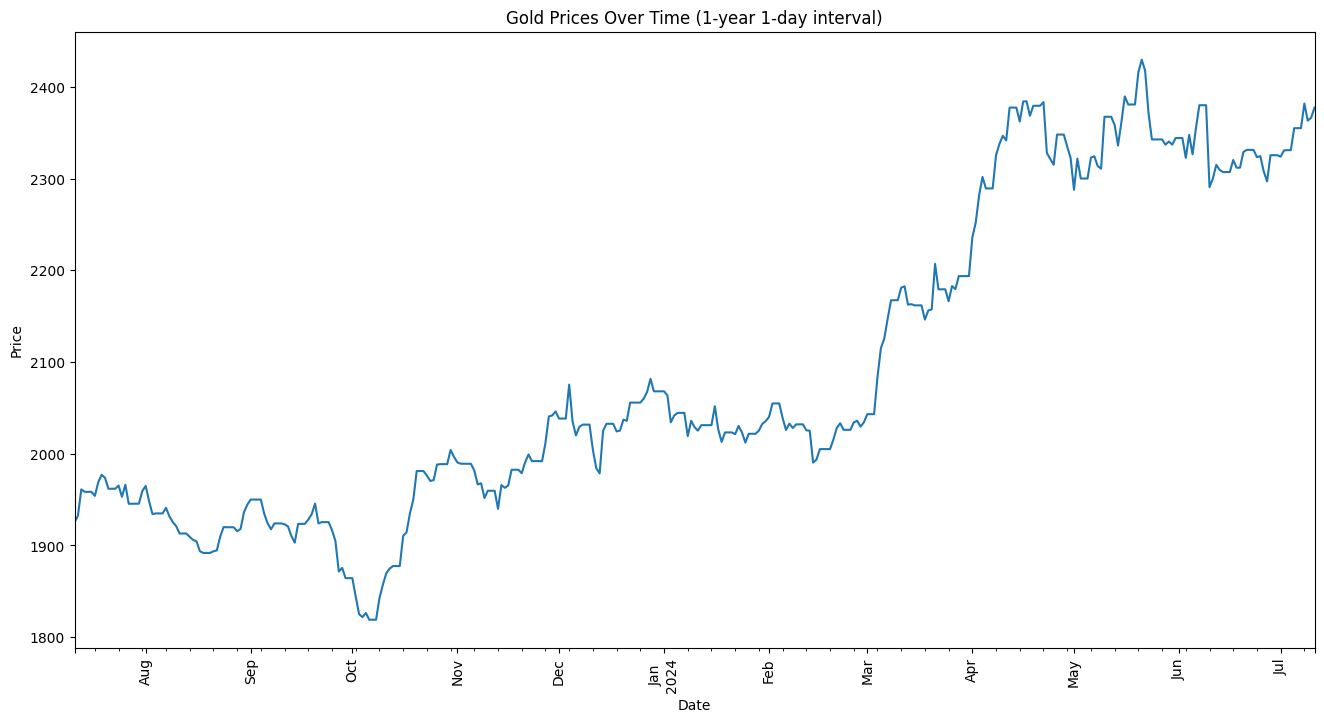

In [74]:
# Create a plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the DataFrame
df_one_year_1['Open'].plot(ax=ax)

plt.title('Gold Prices Over Time (1-year 1-day interval)')
plt.xlabel('Date')
plt.ylabel('Price')

# Rotate x-axis labels 90 degrees
plt.xticks(rotation=90)

# Show plot
plt.show()

# Decomposition 

Applying ARIMA directly do not give the desired output. Need to decompose the timeseries into trend, sesonality and residuals.

In [21]:
ss_decomposition = seasonal_decompose(df_one_year_1['Close'], model='additive')
# trend
estimated_trend = ss_decomposition.trend
# seasonal
estimated_seasonal = ss_decomposition.seasonal
# residual
estimated_residual = ss_decomposition.resid

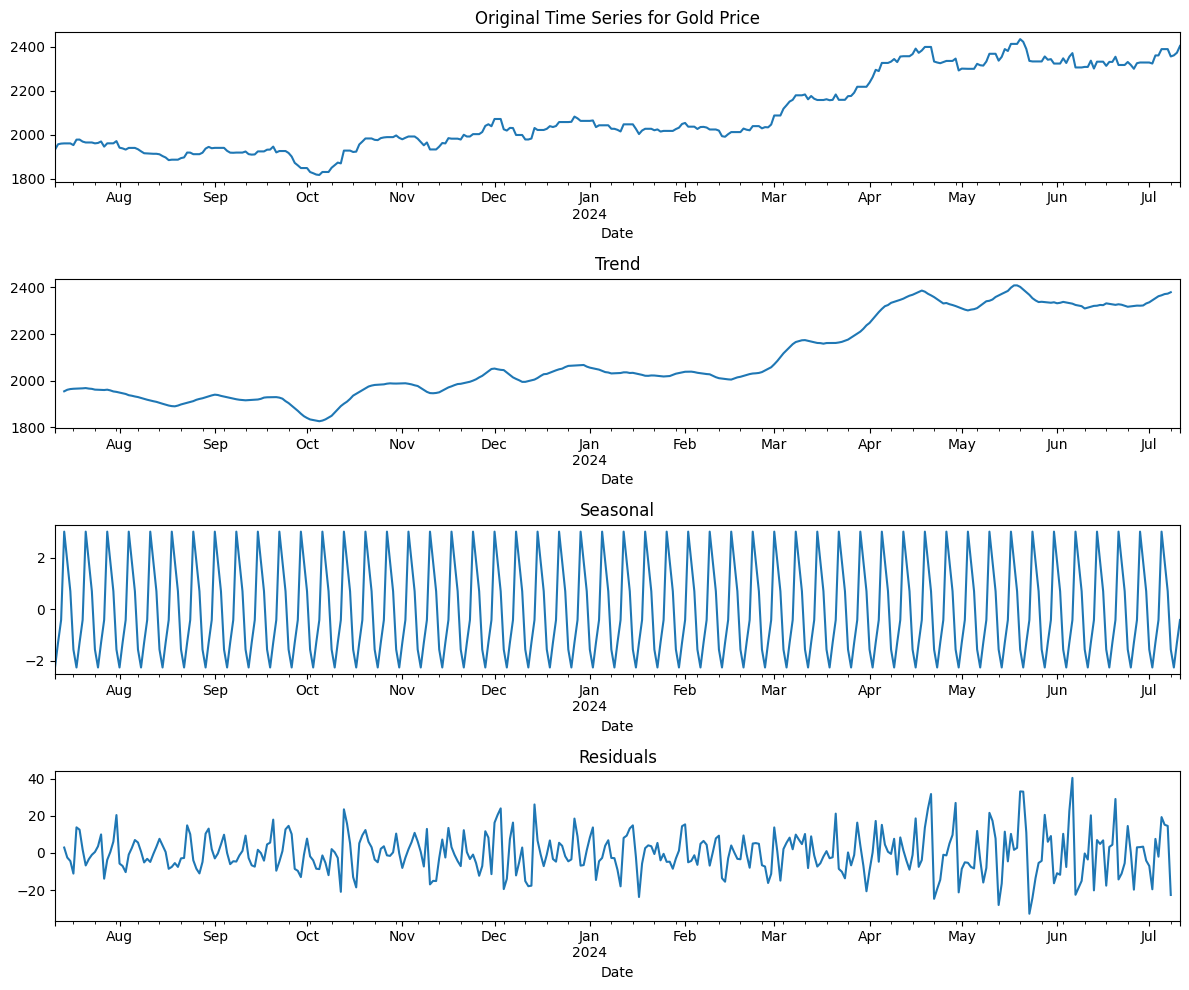

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

df_one_year_1['Close'].plot(ax=ax1, title='Original Time Series for Gold Price')
ss_decomposition.trend.plot(ax=ax2, title='Trend')
ss_decomposition.seasonal.plot(ax=ax3, title='Seasonal')
ss_decomposition.resid.plot(ax=ax4, title='Residuals')

plt.tight_layout()
plt.show()

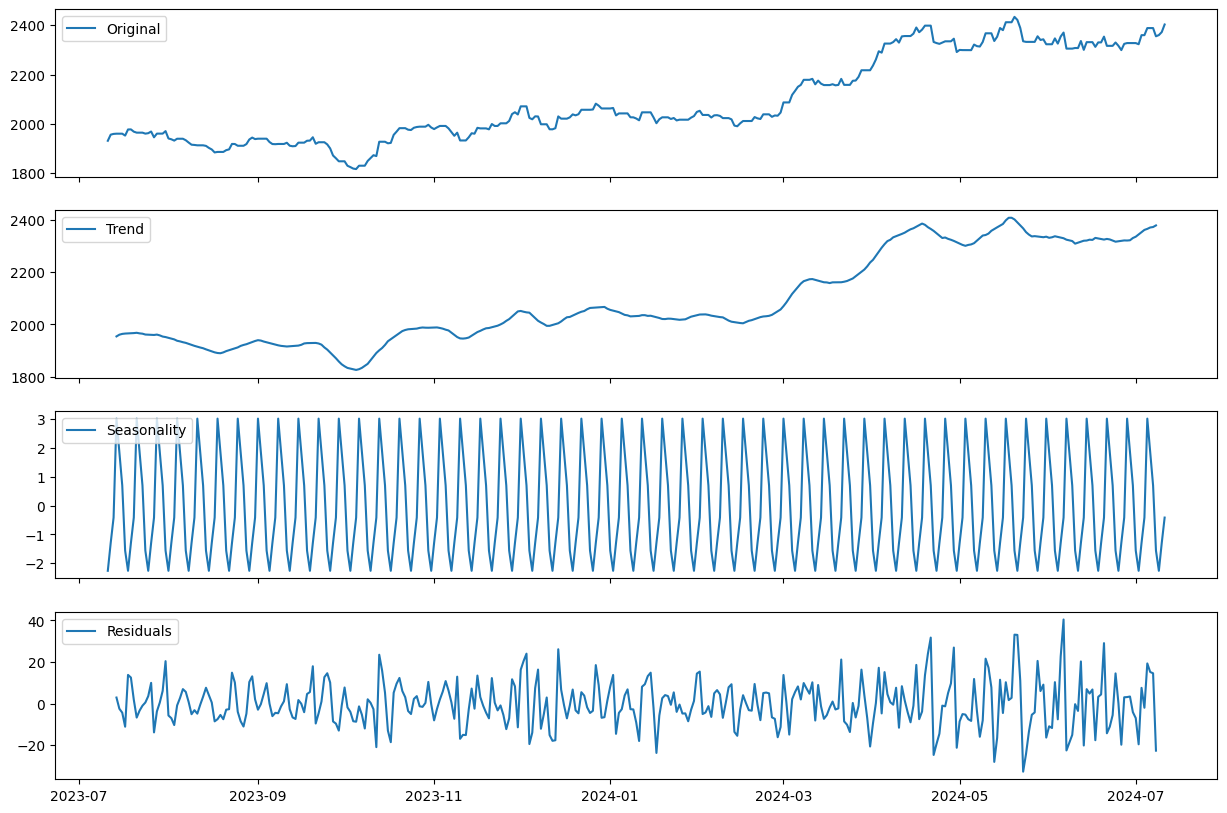

In [23]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(df_one_year_1['Close'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

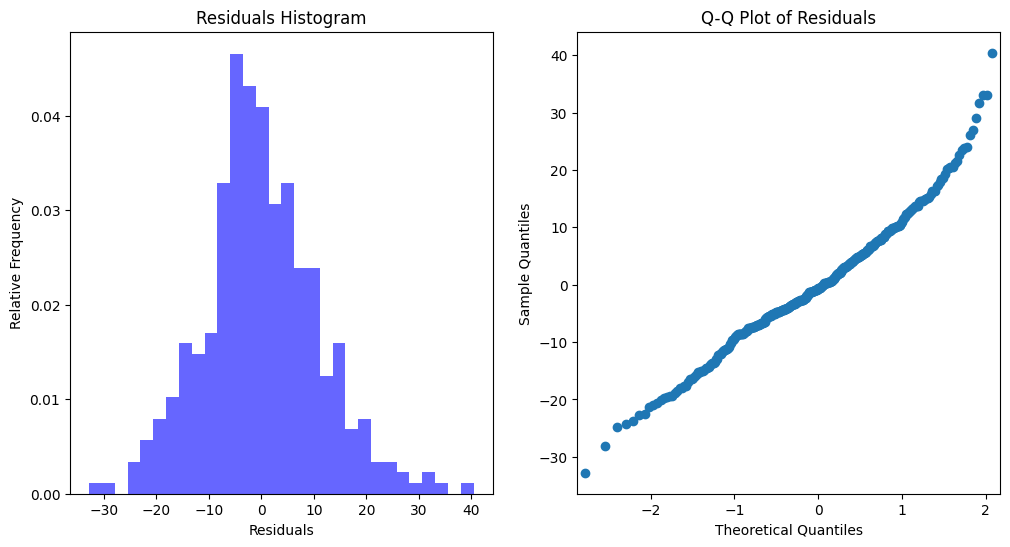

In [24]:
import statsmodels.api as sm
#Histogram for the Residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(ss_decomposition.resid, bins=30, density=True, alpha=0.6, color='b')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Relative Frequency')

#Q-Q plot of the residuals
plt.subplot(1, 2, 2)
sm.qqplot(ss_decomposition.resid, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals')

plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


<Figure size 1200x600 with 0 Axes>

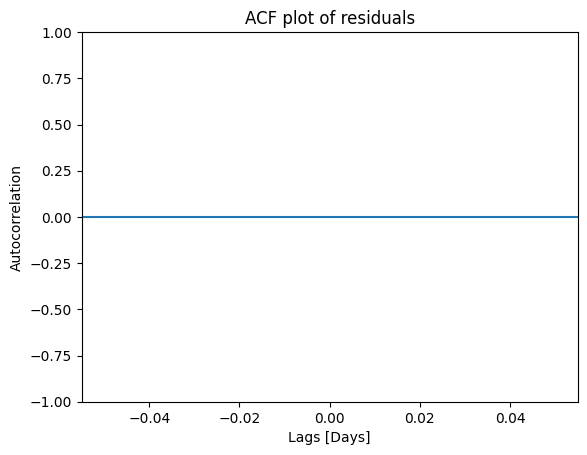

In [25]:
plt.figure(figsize=(12,6))
plot_acf(ss_decomposition.resid)
plt.title('ACF plot of residuals')
plt.xlabel('Lags [Days]')
plt.ylabel('Autocorrelation')
plt.show()

In [26]:
ss_decomposition.trend

Date
2023-07-11            NaN
2023-07-12            NaN
2023-07-13            NaN
2023-07-14    1954.199986
2023-07-15    1960.757115
                 ...     
2024-07-07    2373.257150
2024-07-08    2379.428571
2024-07-09            NaN
2024-07-10            NaN
2024-07-11            NaN
Freq: D, Name: trend, Length: 367, dtype: float64

In [27]:
trend=ss_decomposition.trend.dropna()
trend

Date
2023-07-14    1954.199986
2023-07-15    1960.757115
2023-07-16    1963.799979
2023-07-17    1965.099993
2023-07-18    1965.700003
                 ...     
2024-07-04    2362.242885
2024-07-05    2366.185721
2024-07-06    2371.485735
2024-07-07    2373.257150
2024-07-08    2379.428571
Freq: D, Name: trend, Length: 361, dtype: float64

Text(0, 0.5, 'Autocorrelation')

<Figure size 1200x600 with 0 Axes>

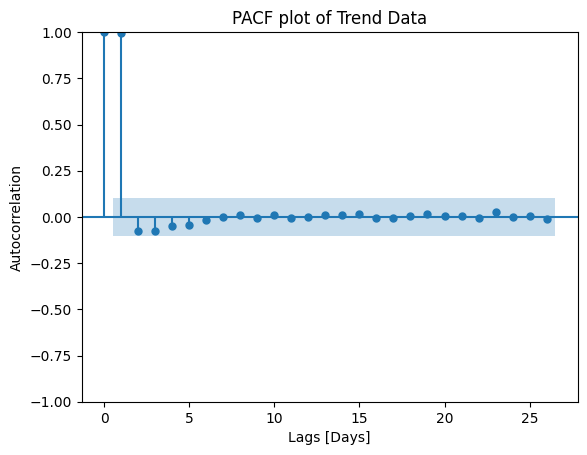

In [28]:
plt.figure(figsize=(12,6))
plot_pacf(trend)
plt.title('PACF plot of Trend Data')
plt.xlabel('Lags [Days]')
plt.ylabel('Autocorrelation')

In [29]:
#Splitting the trend data into the training set and the test set
y_train=trend[:int(0.80*len(trend))]
print(int(0.8*len(trend)))
print(len(trend))
y_test=trend[int(0.80*len(trend)):]


#Here's the code for the forecast, using walk-forward validation

y_prediction = pd.Series() #Starts an empty series to store the predicted values

history = y_train.copy() #Training set starts with y_train, and gradually increases by 1 observation with each passing day.

288
361


In [30]:
len(y_test)

73

In [31]:
for i in range(1,1+len(y_test)):

    ARIMA_Model=ARIMA(history,order=(4,1,1)).fit() #Model is trained on history which increases with each loop

    next_prediction=ARIMA_Model.forecast()  #Gives the prediction for the next timestamp
    
    y_prediction=pd.concat([y_prediction, next_prediction]) #Puts all the predictions and timestamps into the series y_prediction
    
    history=trend[:len(y_train)+i] #Training set increases by one observation in preparation for the next loop

C:\Users\user\AppData\Local\Temp\ipykernel_12860\386236576.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_prediction=pd.concat([y_prediction, next_prediction]) #Puts all the predictions and timestamps into the series y_prediction


In [32]:
future_days = 10
# Creating a list to store future dates
last_date = trend.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_days + 1)

In [33]:
# Extending the loop to include the future days
for i in range(1, 1 + len(y_test) + future_days):
    ARIMA_Model = ARIMA(history, order=(4, 1, 1)).fit()  # Model is trained on history which increases with each loop

    next_prediction = ARIMA_Model.forecast()  # Gives the prediction for the next timestamp
    
    # Setting the index for the next prediction
    if i <= len(y_test):
        next_date = trend.index[len(y_train) + i - 1]
    else:
        next_date = future_dates[i - len(y_test) - 1]
    
    next_prediction.index = [next_date]
    
    # Puts all the predictions and timestamps into the series y_prediction
    prediction = pd.concat([y_prediction, next_prediction])  
    
    if i <= len(y_test):
        # Continue updating the history with actual test data
        history = trend[:len(y_train) + i]  # Training set increases by one observation in preparation for the next loop
    else:
        # After test data, keep updating history with predictions
        history = pd.concat([history, next_prediction])

# Print the forecast for the future days
print(prediction[-future_days:])

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is availab

2024-06-30    2323.346623
2024-07-01    2338.242714
2024-07-02    2341.048844
2024-07-03    2352.789459
2024-07-04    2361.272121
2024-07-05    2370.051447
2024-07-06    2369.894509
2024-07-07    2375.672492
2024-07-08    2374.351350
2024-07-17    2391.605272
dtype: float64


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [34]:
y_prediction

2024-04-27    2335.180199
2024-04-28    2323.914761
2024-04-29    2322.743314
2024-04-30    2316.407137
2024-05-01    2310.744049
                 ...     
2024-07-04    2361.272121
2024-07-05    2370.051447
2024-07-06    2369.894509
2024-07-07    2375.672492
2024-07-08    2374.351350
Freq: D, Length: 73, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


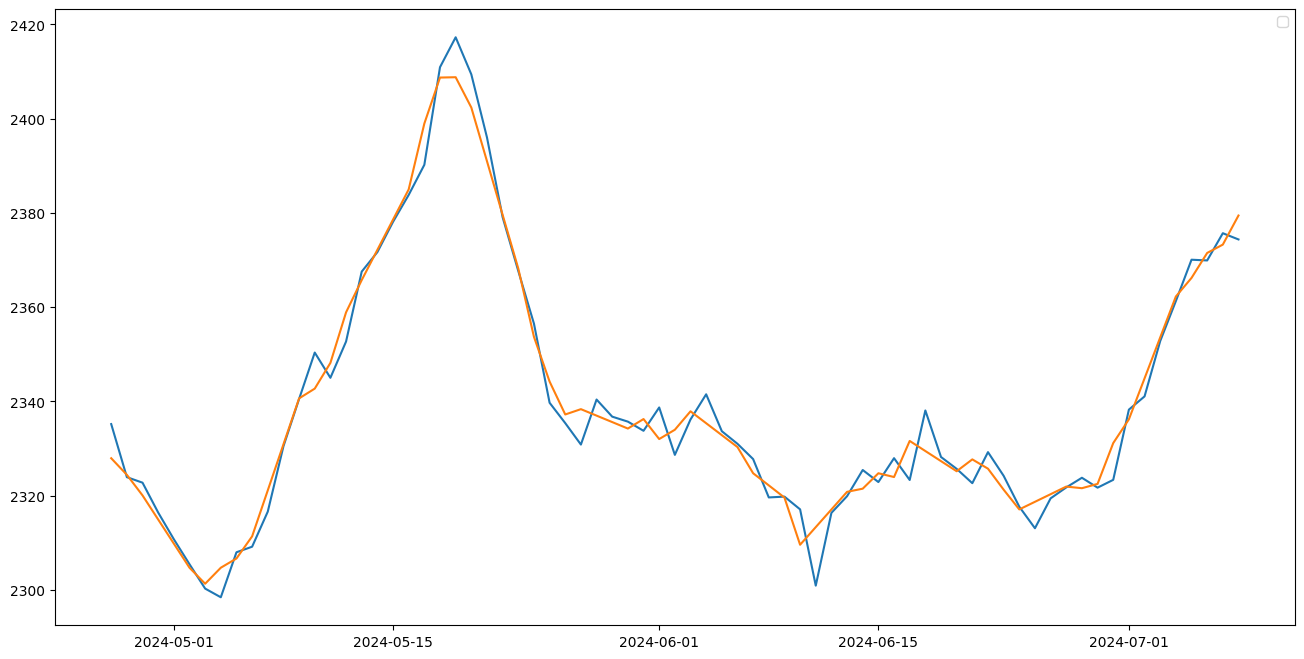

In [35]:
plt.figure(figsize=(16,8))
plt.plot(y_prediction)
plt.plot(y_test)
plt.legend()
plt.show()

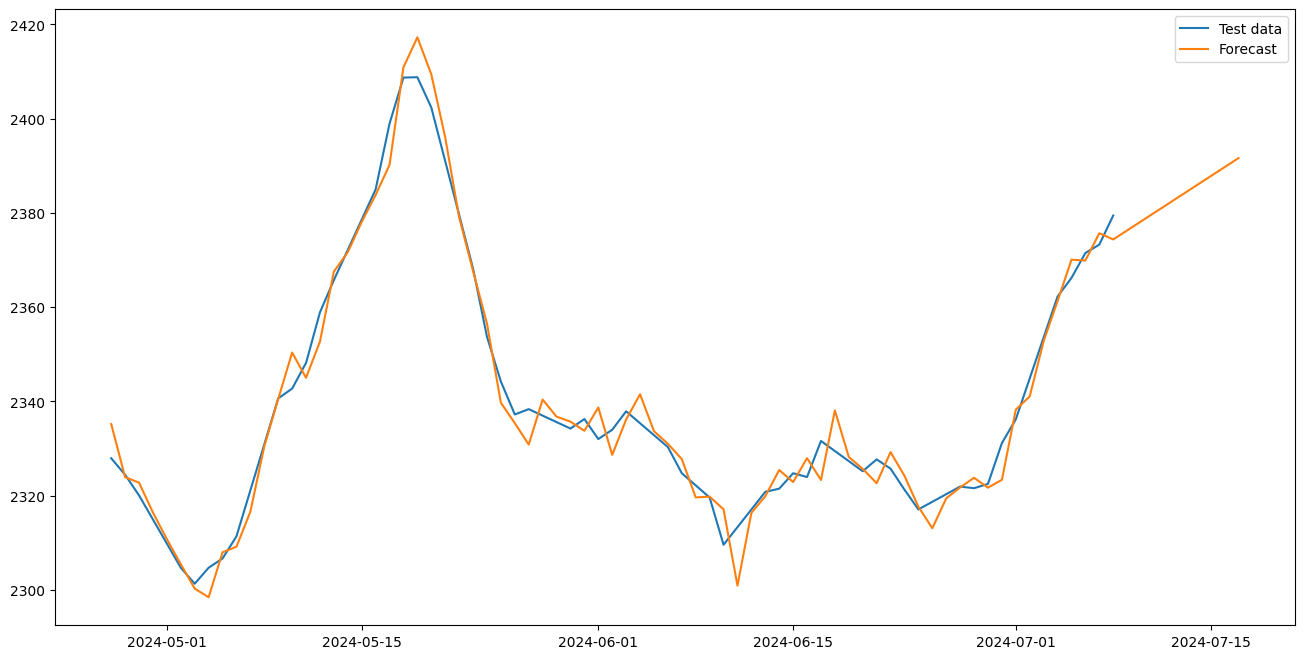

In [36]:
plt.figure(figsize=(16,8))
plt.plot(y_test, label="Test data")
plt.plot(prediction, label="Forecast")
plt.legend()
plt.show()

In [37]:
# Calculate and print evaluation metrics
mae = mean_absolute_error(y_test, y_prediction)
rmse = np.sqrt(mean_squared_error(y_test, y_prediction))

print('MAE:', mae)
print('RMSE:', rmse)

MAE: 3.220719279787106
RMSE: 4.249010774107043


In [38]:
df_one_year_1.tail(10)

,Open,High,Low,Close
Date,,,,
2024-07-02,2330.699951,2334.600098,2323.000000,2323.000000
2024-07-03,2330.899902,2361.600098,2330.899902,2359.800049
2024-07-04,2330.899902,2361.600098,2330.899902,2359.800049
2024-07-05,2354.899902,2388.500000,2354.899902,2388.500000
2024-07-06,2354.899902,2388.500000,2354.899902,2388.500000
2024-07-07,2354.899902,2388.500000,2354.899902,2388.500000
2024-07-08,2381.699951,2383.800049,2352.800049,2355.199951
2024-07-09,2363.100098,2363.699951,2360.100098,2360.100098
2024-07-10,2366.300049,2377.000000,2365.800049,2372.199951


In [39]:
df_one_year_1['prediction'] = y_prediction

Text(0, 0.5, 'Autocorrelation')

<Figure size 1000x500 with 0 Axes>

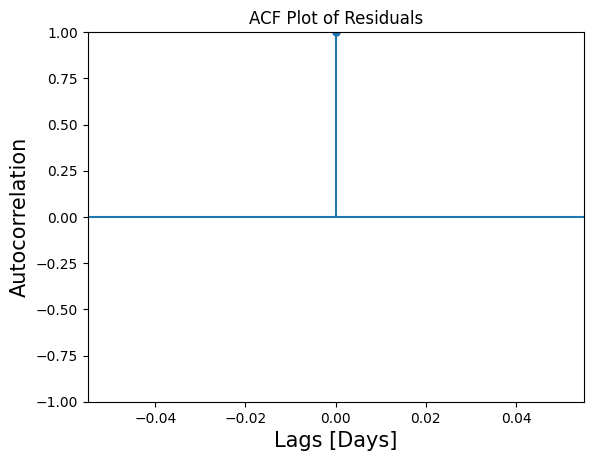

In [40]:
plt.figure(figsize=(10, 5))
plot_pacf(ss_decomposition.resid, lags=50)
plt.title('ACF Plot of Residuals')
plt.xlabel("Lags [Days]", fontsize=15) 
plt.ylabel("Autocorrelation", fontsize=15)

# Check Stationarity 

It is obvious that the data is non-stationarity according to the visualization. But, to make sure check with the statistics method.

In [41]:
# check with adfuller methods
result = adfuller(df_one_year_1['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.1189206350488162
p-value: 0.9475210502496719


Hypothesis testing 

If p-value < 0.05, reject the null hypothesis.
If not, fail to reject the null hypothesis.

In [42]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(df):
    """A method for testing hypothesis for data stationarity.

        input
        -----
        df: dataframe 

        output
        ------
        ADF: 
        p-value: the significant value
        Lags: the significant lags / spikes
        No.of observation: the numbers of lags that observe
    """
    # assign the column into Augmented Dickey-Fuller Test (ADF)
    result=adfuller(df)
    # creat a list of labels 
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    # zip the value and label together 
    for value,label in zip(result,labels):
        # print the label and value 
        print(label+' : '+str(value) )
    # if p-value is less than 0.05,
    if result[1] <= 0.05:
        # reject the null hypothesis 
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    # if not,
    else:
        # fail to reject null hypothesis
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [43]:
adfuller_test(df_one_year_1['Close'])

ADF Test Statistic : -0.1189206350488162
p-value : 0.9475210502496719
#Lags Used : 0
Number of Observations Used : 366
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


# Differencing

Since the original is non-stationarity, we need to difference the time series data to determine degree of integration "d" to make the data stationarity. 

In [44]:
# first order differencing 
df_one_year_1d = df_one_year_1['Close'].diff()
# test the hypothesis
adfuller_test(df_one_year_1d.dropna())

ADF Test Statistic : -19.722138548778492
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 365
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


The data becomes sationary. To make sure, find the second order differencing of the data too. 

In [45]:
# first order differencing 
df_one_year_2d = df_one_year_1['Close'].diff().diff()
# test the hypothesis
adfuller_test(df_one_year_2d.dropna())

ADF Test Statistic : -7.187094848007063
p-value : 2.5600058404994736e-10
#Lags Used : 17
Number of Observations Used : 347
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Since the data become stationary at degree of integration one, we can choose one as our "d" value.

In [46]:
# d = 1

After determining "d", we need to consider "p" and "q". We need to visualize ACFs and PACFs to determine those values.

<BarContainer object of 20 artists>

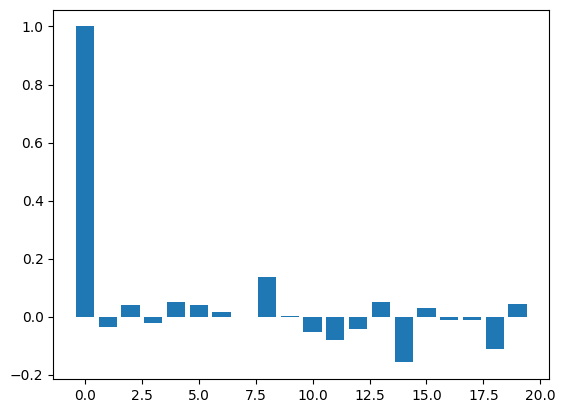

In [47]:
# acf 
num_lags = 20
acf_values = acf(df_one_year_1.Close.diff().dropna())
plt.bar(range(num_lags), acf_values[:num_lags])

<BarContainer object of 20 artists>

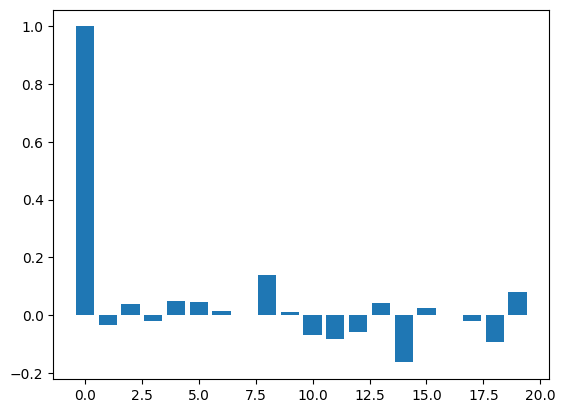

In [48]:
# pacf 
num_lags = 20
pacf_values = pacf(df_one_year_1.Close.diff().dropna())
plt.bar(range(num_lags), pacf_values[:num_lags])

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


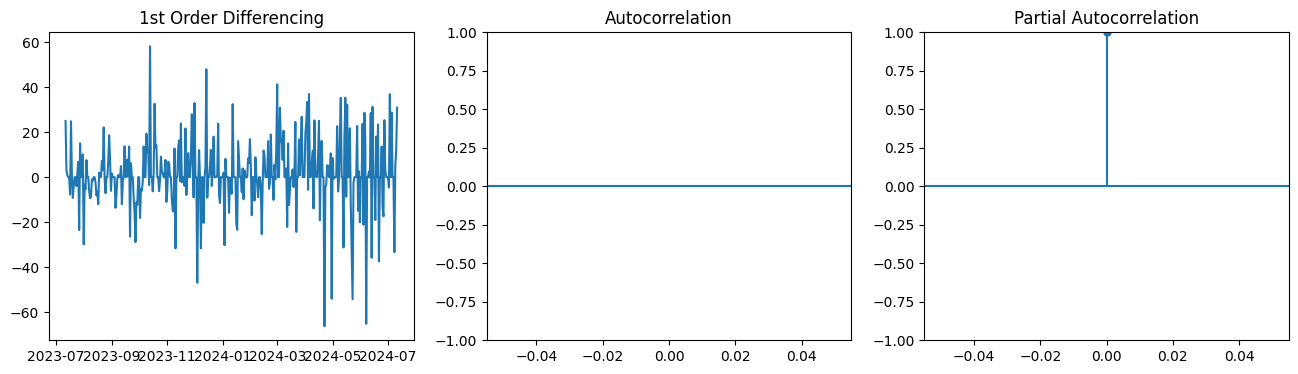

In [49]:
# plot first order differencing
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(131)  # Corrected typo here
ax1.set_title('1st Order Differencing')
ax1.plot(df_one_year_1.Close.diff());

ax2 = fig.add_subplot(132)
plot_acf(df_one_year_1.Close.diff(), ax=ax2, lags=20);

ax3 = fig.add_subplot(133)
plot_pacf(df_one_year_1.Close.diff(), ax=ax3, lags=20);

plt.show()

According to the ACFs and PACFs, there is one lag at PACFs. Therefore, p = 1. No signigicant lag in ACFs. The value of "q" is zero.

# ARIMA Model Implementation

In [50]:
len(df_one_year_1.Close)

367

In [51]:
# split train test data 
train_data = int(len(df_one_year_1.Close) * 0.8)
test_data = int(len(df_one_year_1.Close)-train_data)
print("No. of train data: ",train_data)
print("No. of test data:", test_data)
train_data_df = df_one_year_1[0:train_data]
test_data_df = df_one_year_1[train_data:]



No. of train data:  293
No. of test data: 74


In [52]:
train_data_df.head(3)

,Open,High,Low,Close,prediction
Date,,,,,
2023-07-11,1925.000000,1937.000000,1924.199951,1931.300049,NaN
2023-07-12,1932.300049,1958.000000,1932.199951,1956.199951,NaN
2023-07-13,1961.099976,1961.099976,1953.000000,1959.199951,NaN


In [53]:
train_data_df.tail()

,Open,High,Low,Close,prediction
Date,,,,,
2024-04-24,2321.300049,2328.699951,2314.600098,2324.500000,NaN
2024-04-25,2315.000000,2329.800049,2305.000000,2329.800049,NaN
2024-04-26,2347.899902,2347.899902,2332.800049,2334.800049,NaN
2024-04-27,2347.899902,2347.899902,2332.800049,2334.800049,2335.180199
2024-04-28,2347.899902,2347.899902,2332.800049,2334.800049,2323.914761


In [54]:
test_data_df.head(5)

,Open,High,Low,Close,prediction
Date,,,,,
2024-04-29,2334.800049,2345.500000,2327.899902,2345.399902,2322.743314
2024-04-30,2322.500000,2322.500000,2291.399902,2291.399902,2316.407137
2024-05-01,2287.699951,2327.300049,2283.800049,2299.899902,2310.744049
2024-05-02,2321.699951,2324.699951,2292.300049,2299.199951,2305.443356
2024-05-03,2300.000000,2301.000000,2277.600098,2299.000000,2300.270538


In [55]:
test_data_df.tail()

,Open,High,Low,Close,prediction
Date,,,,,
2024-07-07,2354.899902,2388.500000,2354.899902,2388.500000,2375.672492
2024-07-08,2381.699951,2383.800049,2352.800049,2355.199951,2374.351350
2024-07-09,2363.100098,2363.699951,2360.100098,2360.100098,NaN
2024-07-10,2366.300049,2377.000000,2365.800049,2372.199951,NaN
2024-07-11,2377.399902,2418.699951,2376.800049,2403.000000,NaN


In [56]:
from pmdarima import auto_arima

stepwise_model = auto_arima(train_data_df['Close'], start_p=1, start_q=1,
                            max_p=3, max_q=3, seasonal=False,
                            d=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2340.497, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2339.640, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2341.291, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2341.327, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2340.821, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.895 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  293
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1167.820
Date:                Thu, 11 Jul 2024   AIC                           2339.640
Time:                        20:28:57   BIC                           2346.993
Sample:                    07-11-2023   HQIC                          2342.585
                         - 04-28-2024                                       

According to autoarima, the best parameters are p = 2, d = 1 and q = 2.

In [57]:
# p = 2, d = 1, q = 2

model = ARIMA(train_data_df.Close, order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  293
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1165.053
Date:                Thu, 11 Jul 2024   AIC                           2340.105
Time:                        20:28:59   BIC                           2358.489
Sample:                    07-11-2023   HQIC                          2347.469
                         - 04-28-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7972      0.154     11.703      0.000       1.496       2.098
ar.L2         -0.8610      0.136     -6.330      0.000      -1.128      -0.594
ma.L1         -1.7686      0.136    -12.978      0.0

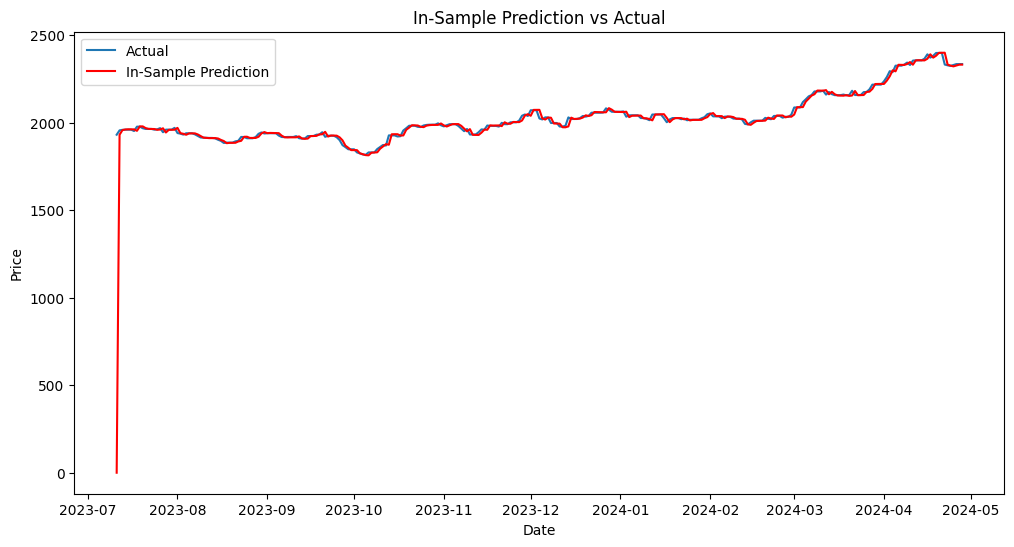

In [58]:
# In-sample predictions
in_sample_pred = model_fit.predict(start=train_data_df.index[0], end=train_data_df.index[-1])

# Plot in-sample predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train_data_df.index, train_data_df['Close'], label='Actual')
plt.plot(train_data_df.index, in_sample_pred, label='In-Sample Prediction', color='red')
plt.title('In-Sample Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [59]:
test_data_df.index[0]

Timestamp('2024-04-29 00:00:00')

In [60]:
#get the predictions and residuals
model_fit.fittedvalues

Date
2023-07-11       0.000000
2023-07-12    1931.319179
2023-07-13    1957.623040
2023-07-14    1961.050357
2023-07-15    1962.109943
                 ...     
2024-04-24    2325.945850
2024-04-25    2321.737161
2024-04-26    2326.583917
2024-04-27    2331.587290
2024-04-28    2331.839697
Freq: D, Length: 293, dtype: float64

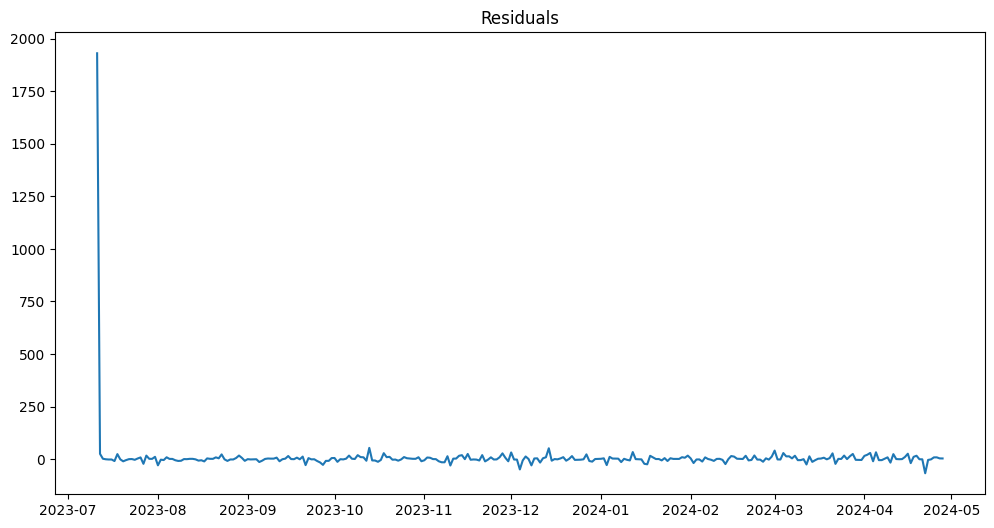

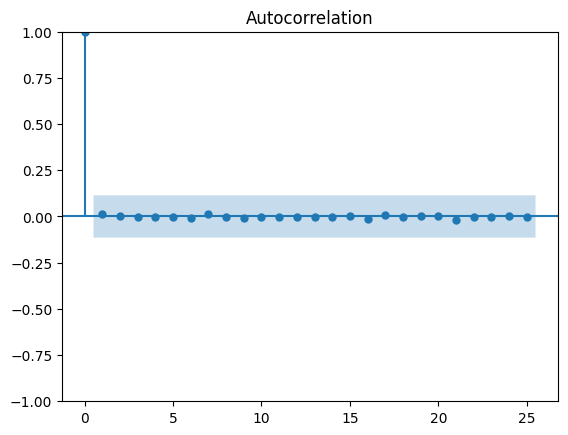

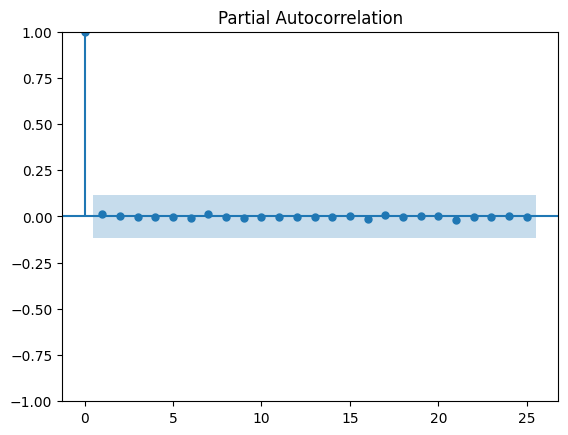

In [61]:
# residual plotting
residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

plot_acf(residuals)
plot_pacf(residuals)
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


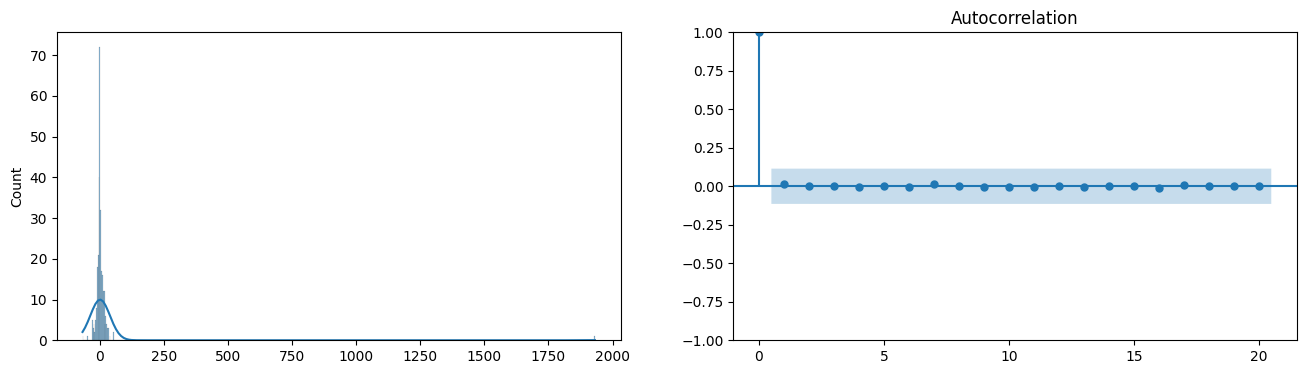

In [62]:
residuals = model_fit.resid
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(residuals, kde=True, ax=ax[0])
plot_acf(residuals, lags=20, ax=ax[1])
plt.show()


In [63]:
train_data_df.head(5)

,Open,High,Low,Close,prediction
Date,,,,,
2023-07-11,1925.000000,1937.000000,1924.199951,1931.300049,NaN
2023-07-12,1932.300049,1958.000000,1932.199951,1956.199951,NaN
2023-07-13,1961.099976,1961.099976,1953.000000,1959.199951,NaN
2023-07-14,1958.400024,1960.599976,1952.699951,1960.099976,NaN
2023-07-15,1958.400024,1960.599976,1952.699951,1960.099976,NaN


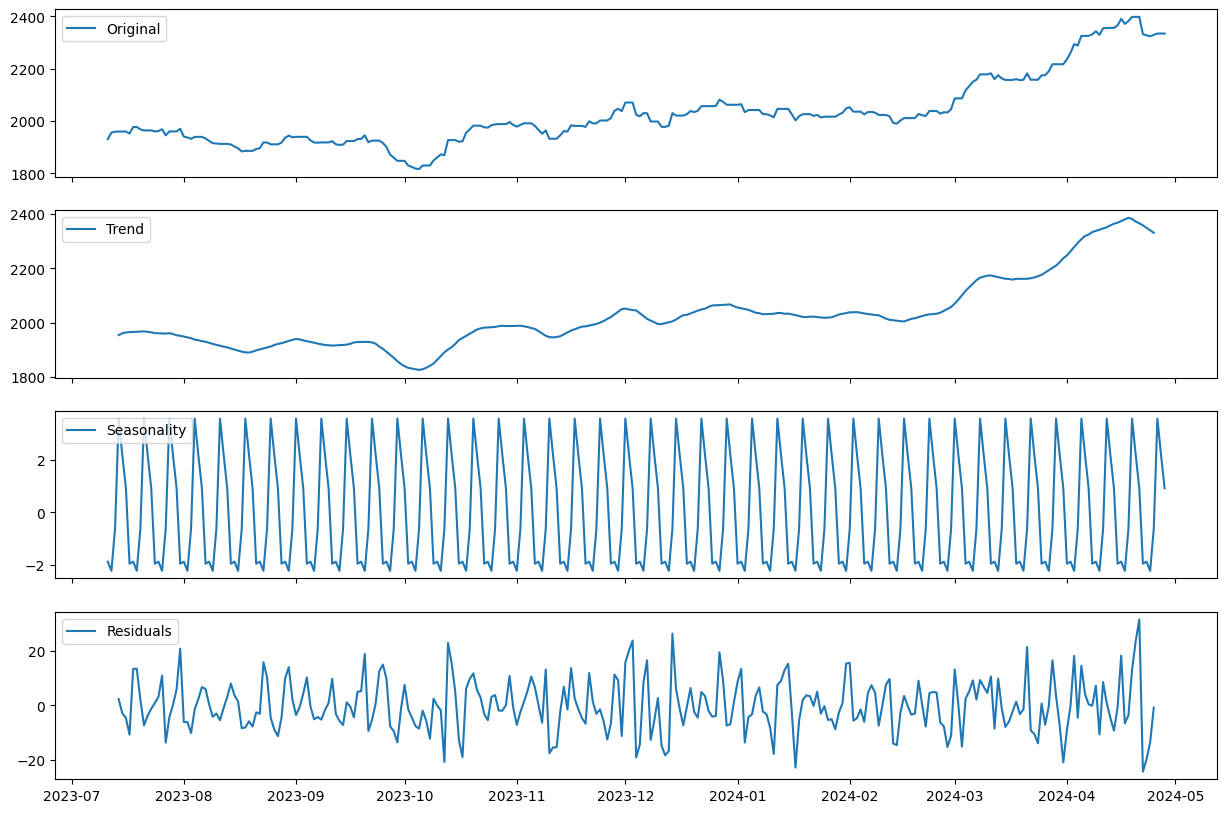

In [64]:
train_decomposition = seasonal_decompose(train_data_df['Close'], model='additive')
# trend
train_trend = train_decomposition.trend
# seasonal
train_seasonal = train_decomposition.seasonal
# residual
train_residual = train_decomposition.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(train_data_df['Close'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(train_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(train_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(train_residual, label='Residuals')
axes[3].legend(loc='upper left');

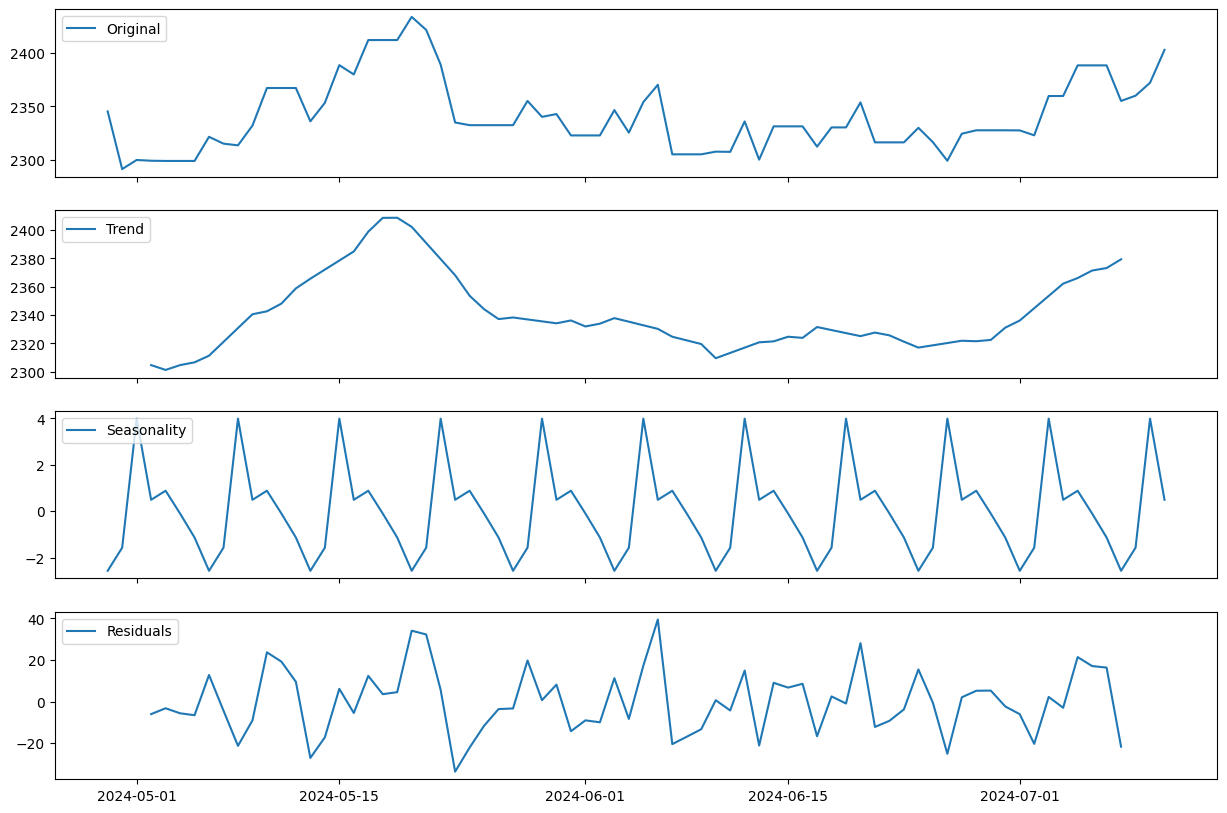

In [65]:
test_decomposition = seasonal_decompose(test_data_df['Close'], model='additive')
# trend
test_trend = test_decomposition.trend
# seasonal
test_seasonal = test_decomposition.seasonal
# residual
test_residual = test_decomposition.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(test_data_df['Close'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(test_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(test_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(test_residual, label='Residuals')
axes[3].legend(loc='upper left');

In [66]:
test_seasonal

Date
2024-04-29   -2.564147
2024-04-30   -1.569579
2024-05-01    3.987597
2024-05-02    0.492996
2024-05-03    0.882951
                ...   
2024-07-07   -1.131338
2024-07-08   -2.564147
2024-07-09   -1.569579
2024-07-10    3.987597
2024-07-11    0.492996
Freq: D, Name: seasonal, Length: 74, dtype: float64

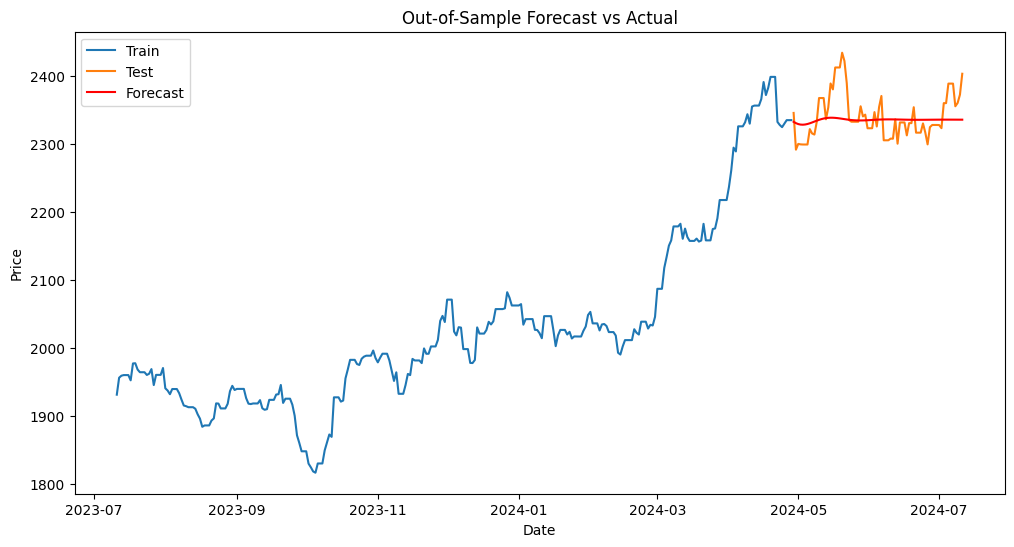

In [67]:
# Out-of-sample forecast
forecast_steps = len(test_data_df)
out_sample_forecast = model_fit.forecast(steps=forecast_steps)

# Plot forecast vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train_data_df.index, train_data_df['Close'], label='Train')
plt.plot(test_data_df.index, test_data_df['Close'], label='Test')
plt.plot(test_data_df.index, out_sample_forecast, label='Forecast', color='red')
plt.title('Out-of-Sample Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

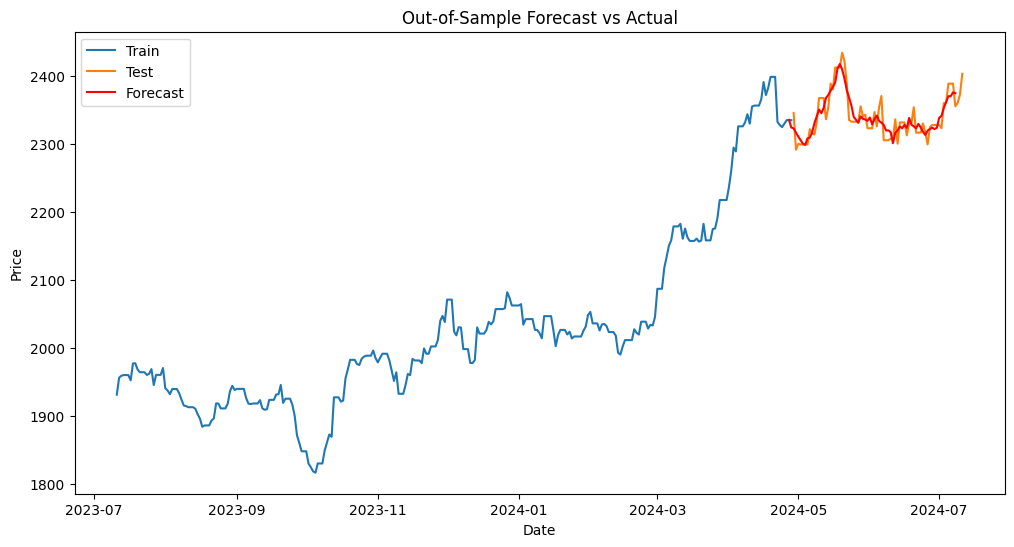

In [68]:
# Plot forecast vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train_data_df.index, train_data_df['Close'], label='Train')
plt.plot(test_data_df.index, test_data_df['Close'], label='Test')
plt.plot(df_one_year_1.index, df_one_year_1.prediction, label='Forecast', color='red')
plt.title('Out-of-Sample Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [69]:
# Calculate and print evaluation metrics
mae = mean_absolute_error(test_data_df['Close'], out_sample_forecast)
rmse = np.sqrt(mean_squared_error(test_data_df['Close'], out_sample_forecast))

print('MAE:', mae)
print('RMSE:', rmse)

MAE: 24.81562735847817
RMSE: 32.77600928962329


In [70]:
test_data_df["Prediction"] = model_fit.forecast(len(test_data_df))

test_data_df

C:\Users\user\AppData\Local\Temp\ipykernel_12860\735620623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_df["Prediction"] = model_fit.forecast(len(test_data_df))


,Open,High,Low,Close,prediction,Prediction
Date,,,,,,
2024-04-29,2334.800049,2345.500000,2327.899902,2345.399902,2322.743314,2332.312066
2024-04-30,2322.500000,2322.500000,2291.399902,2291.399902,2316.407137,2330.372504
2024-05-01,2287.699951,2327.300049,2283.800049,2299.899902,2310.744049,2329.028925
2024-05-02,2321.699951,2324.699951,2292.300049,2299.199951,2305.443356,2328.284233
2024-05-03,2300.000000,2301.000000,2277.600098,2299.000000,2300.270538,2328.102707
...,...,...,...,...,...,...
2024-07-07,2354.899902,2388.500000,2354.899902,2388.500000,2375.672492,2335.538799
2024-07-08,2381.699951,2383.800049,2352.800049,2355.199951,2374.351350,2335.527758
2024-07-09,2363.100098,2363.699951,2360.100098,2360.100098,NaN,2335.515541


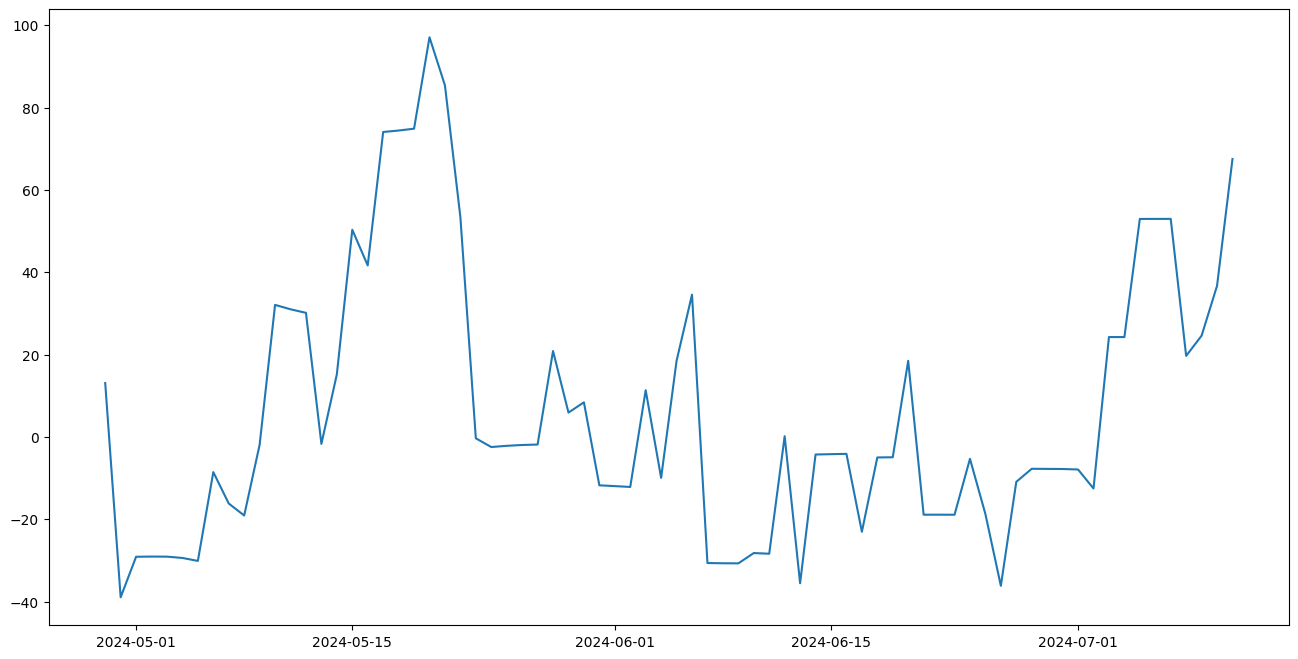

In [71]:
residuals = test_data_df['Close'] - out_sample_forecast
plt.figure(figsize=(16,8))
plt.plot(residuals)
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<Figure size 3200x800 with 0 Axes>

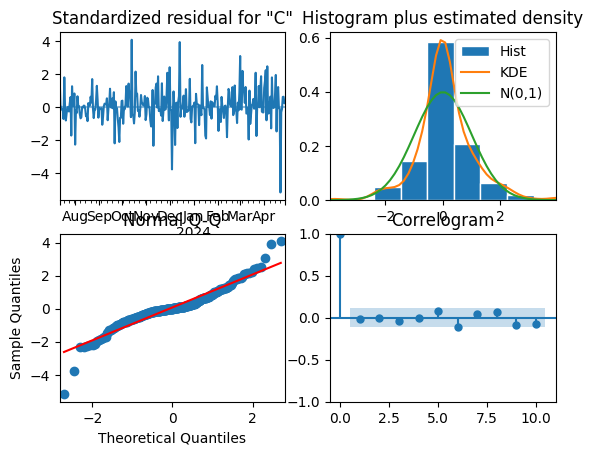

In [72]:
fig = plt.figure(figsize=(32, 8))
model.fit().plot_diagnostics()
plt.show()

In [73]:
output = model_fit.forecast()
print(output)

2024-04-29    2332.312066
Freq: D, dtype: float64
